# Introdução
Nesse notebook, o que a hiperaparametrização encontrada na exploração do modelo
vai ser utilizada para gerar o modelo final de categorização de produtos. O
modelo vai ser salvo para futura utilização pelo script principal do projeto.

# Imports

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import joblib
import ast

# preprocessamento nlp e modelagem de tópicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
# modelagem de árvores
from sklearn.ensemble import RandomForestClassifier
# criação de pipelines
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
from pathlib import Path
import sys

main_path = str(Path().resolve().parent)
sys.path.append(main_path)

In [3]:
# carregando as funções de preprocessamento nlp do notebook de
# análise de produto, essas funções foram adicionadas nesse modulo
from src import nlp_preprocessing

# Treinando o modelo
Carregando os dados, para otimizar a modelagem todos os dados serão utilizados

In [5]:
df = pd.concat([pd.read_pickle("../data/train_prod.pickle"),
                pd.read_pickle("../data/test_prod.pickle")])
df.head()

,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,
7010568,761717,Caneta Personalizada Barquinho,caneta personalizada canetas personalizadas pa...,2017-07-12 16:29:08,12.260,15.0,0,30.0,116.0,11.0,Lembrancinhas
6957815,3708390,Toalha Bordada Madrinha de Consagração,toalhas lavabo lembrancinhas batizado toalha c...,2016-12-08 10:40:28,28.490,7.5,1,4.5,463.0,8.5,Lembrancinhas
10378129,8225602,Colar Best Friends Folheado 4 Partes.,biju best friends mirella flavia gabi,2017-01-24 14:32:48,40.290,13.0,0,0.0,9183.0,157.0,Bijuterias e Jóias
4658013,7043431,Azulejo Certificado Melhor Pai do Mundo,dia pais azulejos,2019-06-14 16:09:23,39.220,338.0,0,1.0,77.5,12.0,Decoração
487440,1408350,Mochila saco bailarina soldadinho de chumbo,sacolinhas festa bailarina lembrancinhas baila...,2018-02-21 16:39:27,13.175,12.5,1,32.0,1484.5,0.0,Lembrancinhas


Carregando os parâmetros para a modelagem

In [11]:
with open("../config/rf_category_clf.json", "r") as file:
    rf_params = json.load(file)

with open("../config/tags_nmf.json", "r") as file:
    tags_nmf_params = json.load(file)
    
with open("../config/title_nmf.json", "r") as file:
    title_nmf_params = json.load(file)

gerando as funções de seleção de dados

In [9]:
base_features = ["price", "weight", "minimum_quantity"]
def select_base_features(X):
    return X[base_features]

In [27]:
def select_txt(X, col):
        return X[col]

criando a função para fazer a modelagem de tópicos (uma modificação para
aceitar o dicionário de configuração do NMF).

In [28]:
def gen_topic_transformer(column_name: str, nmf_config: dict) -> Pipeline:
    """Gera um pipeline de geração de tópicos NMF a partir de um nome de coluna

    Args:
        column_name (str): nome da feature utilizada

    Returns:
        Pipeline: pipeline de tópicos NMF
    """
    
    return Pipeline(steps=[
        ("selector", FunctionTransformer(select_txt, kw_args={"col": column_name})),
        ("tfidf", TfidfVectorizer(tokenizer=nlp_preprocessing.custom_tokenizer,
                                  preprocessor=nlp_preprocessing.clean_text,
                                  min_df=10,
                                  max_df=0.9)),
        ("nmf", NMF(**nmf_config))
    ])

Agora vamos criar o pipeline e treinar o modelo

In [29]:
feature_pipelines = FeatureUnion([
    ("title", gen_topic_transformer("title", title_nmf_params)),
    ("tags", gen_topic_transformer("concatenated_tags", tags_nmf_params)),
    ("base_selector", FunctionTransformer(select_base_features))
])

pipeline = Pipeline([
    ("preprocessing", feature_pipelines),
    ("rf", RandomForestClassifier(**rf_params))
])

In [30]:
pipeline.fit(df, df["category"])

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('title',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function select_txt at 0x0000022EBB5A4B80>,
                                                                                      kw_args={'col': 'title'})),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=10,
                                                                                  preprocessor=<function clean_text at 0x0000022E888BB1F0>,
                                                                                  tokenizer=<function custom_tokenizer at 0x0000022EBA57B9D0>)...
                                

# Analisando os resultados

Para analisar os resultados vamos identificar as top-15 features mais
importantes. Em seguida, das features de tópicos entre as mais importantes,
veremos quais os tokens mais importantes.

In [31]:
title_columns = [f"titles_{n}"
                 for n in range(title_nmf_params["n_components"])]
tags_columns = [f"tags_{n}"
                for n in range(tags_nmf_params["n_components"])]
columns = title_columns + tags_columns + base_features
len(columns)

53

[]

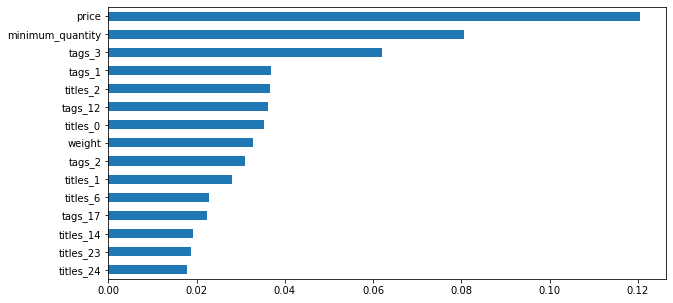

In [32]:
pipeline.named_steps["rf"].feature_importances_
importances = pd.Series(pipeline.named_steps["rf"].feature_importances_,
                        index=columns)
top_15_importances = importances.sort_values().tail(15)
top_15_importances.plot(kind="barh", figsize=(10, 5))
plt.plot()

Vemos que o preço e a quantidade mínima sao das duas features mais importantes.

In [33]:
top_tags_ids = (top_15_importances.
                index[top_15_importances.index.str.contains("tags")].
                str.replace("tags_", "").tolist())
top_title_ids = (top_15_importances.
                 index[top_15_importances.index.str.contains("title")].
                 str.replace("titles_", "").tolist())

In [34]:
topic_pipe = {
    "title": {
        "tfidf": pipeline.named_steps["preprocessing"].transformer_list[0][1][1],
        "nmf": pipeline.named_steps["preprocessing"].transformer_list[0][1][2],
    },
    "tags": {
        "tfidf": pipeline.named_steps["preprocessing"].transformer_list[1][1][1],
        "nmf": pipeline.named_steps["preprocessing"].transformer_list[0][1][2],
    }
}

In [35]:
def show_top_words(topic_model, tfidf_vec, components, n_words=10):
    """Visualização dos top tokens por componente do NMF

    Args:
        topic_model (_type_): modelo NMF treinado
        tfidf_vec (_type_): objeto vetorizador TF-IDF
        n_words (int, optional): número de top tokens. Defaults to 10.
    """
    for i in components:
        component = topic_model.components_[int(i)]
        top_words_ids = list(component.argsort()[:-n_words - 1: -1])
        top_words_list = tfidf_vec.get_feature_names_out()[top_words_ids]
        print(f"Topic {i} - {' | '.join(top_words_list)}")

Para cada tipo de tópico, a ordem está do menos importante para o mais importante.
Os tópicos de titulo são aparentemente mais fáceis de identificar. O tópico 2 parece
ser de lembranças, o tópico 0 de papelatira, o 1 e 6 parecem dividios entre bebe e
lembranças. O tópico 24 e o 23 aparentão ser relacionados a decoração.

In [36]:
show_top_words(topic_pipe["title"]["nmf"], topic_pipe["title"]["tfidf"], top_title_ids)

Topic 24 - quadr | abstrat | mold | sal | fras | namor | fot | pint | tel | casal
Topic 23 - decor | plac | garraf | mdf | espelh | sal | acril | quart | aluguel | letr
Topic 14 - cas | padr | noiv | canec | madr | necessa | convit | alianc | bem | chinel
Topic 6 - matern | said | saqu | urs | mal | enfeit | organiz | vermelh | sac | vest
Topic 1 - bebe | cha | mant | revel | lat | sapat | album | higien | convit | quart
Topic 0 - person | canec | canet | lat | necessa | mochil | acril | bloq | fot | tac
Topic 2 - lembranc | nasc | cha | aromatiz | aniversari | profes | format | sabonet | unicorni | prim


Já os tópicos de tags, não são tão fáceis de se reconhecer. Analisando
superficialmente cada um deles não é claro qual tópico cada um pertence.
Talvez esses tópicos são importantes por capturarem padrões que estão
relacionadas às categorias mais genéricas como a de outros e a de papelaria.

In [37]:
show_top_words(topic_pipe["tags"]["nmf"], topic_pipe["tags"]["tfidf"], top_tags_ids)

Topic 17 - mask | masculin | adesiv | gess | opco | espec | escritori | cervej | cadu | pente
Topic 2 - higien | luis | capuz | aparec | anel | nom | estud | pe | relogi | ninh
Topic 12 - bent | menu | lanc | rebec | lig | isaqu | jennef | pro | banh | alcool
Topic 1 - banh | capuz | juju | par | hei | person | alc | gab | class | opco
Topic 3 - almof | buqu | retr | encomend | boto | mal | miol | monstr | amamentaca | giratori


salvando o modelo para poder utilizá-lo no script principal

In [72]:
joblib.dump(pipeline, "../assets/category_rf_clf_pipeline.joblib", compress=5)

['../assets/category_rf_clf_pipeline.joblib']

# Teste do modelo

Testando o carregamento e a utilização do modelo como deve ser utilizado com
a tag `--category`. Nesse contexto, devemos ser capaz de carregar o modelo,
parsear um string para dicionário, transformar esse dicionário em um dataframe
e em seguida utilizar esse dataframe como input para obter as previsões. Para
assegurar que o modelo vai funcionar podemos inclusive desenvolver uma
funcionalidade que irá testar o string fornecido para validar se ele vai poder
ser utilizado para a previsão.

In [73]:
loaded_model = joblib.load("../assets/category_rf_clf_pipeline.joblib")

In [74]:
str_dict = "{'title': 'Saída de maternidade masculino', 'concatenated_tags': 'bebe menino maternidade roupa', 'price': 70, 'weight': 30, 'minimum_quantity': 1}"
x = ast.literal_eval(str_dict)
x_df = pd.Series(x).to_frame().T

In [75]:
loaded_model.predict(x_df)[0]

'Bebê'